In [1]:
### Import modules

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pandas as pd


In [2]:
### Define a helper function that plots on array of images
### in a nx by ny grid

def plot_images(images,nx,ny,figsize=(15,10),titles=[],fontsize=36,cmap=None,saveas=""):

    fig = plt.figure(figsize=figsize)

    for idx in range(len(images)):
    
        plt.subplot(nx,ny,idx+1)
        plt.imshow(images[idx],cmap=cmap)
        if(len(titles) > idx):
            plt.title(titles[idx],fontsize=fontsize)
    
    display(fig)
    if saveas:
        plt.savefig(saveas,bbox_inches="tight")
    plt.close()
        

In [3]:
# Set up a log file so that when I try different hyperparameters
# and print the results to the screen, the printed results are
# also appened to a log file called vehicle_detection.log
# To use this functionality, use "logging.info()" instead of "print()".

import logging

# set up logging to file - see previous section for more details
logging.basicConfig(level=logging.DEBUG,
                    format='%(message)s',
                    filename='./vehicle_detection.log',
                    filemode='a')
# define a Handler which writes INFO messages or higher to the sys.stderr
console = logging.StreamHandler()
console.setLevel(logging.INFO)
# set a format which is simpler for console use
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
# tell the handler to use this format
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger('').addHandler(console)

# Now, we can log to the root logger, or any other logger. First the root...
#logging.info('Jackdaws love my big sphinx of quartz.')

# Now, define a couple of other loggers which might represent areas in your
# application:

#logger1 = logging.getLogger('myapp.area1')
#logger2 = logging.getLogger('myapp.area2')

#logger1.debug('Quick zephyrs blow, vexing daft Jim.')
#logger1.info('How quickly daft jumping zebras vex.')
#logger2.warning('Jail zesty vixen who grabbed pay from quack.')
#logger2.error('The five boxing wizards jump quickly.')

In [4]:
# Alternatively, because logging.info() displays differently than print(),
# and because logging.info() doesn't take multiple args like print(),
# instead I define printlog() that does both printing and logging, but
# otherwise works the same way as print().

log_fname = 'vehicle_detection.log'

def printlog(*args):
    print(*args)
    vh_logfile = open(log_fname,'a')
    vh_logfile.write('\n'+" ".join(map(str,args)))
    vh_logfile.close()

# Test it out here
#temp = 17
#printlog("asdf",temp,99.1234,'qwerty')

In [5]:
## This cell is no longer how the data is obtained
## Running this cell won't cause any problems,
## because I now keep the data in folders calld
## vehicles_split and non-vehicles_split, which
## already have the data split between train and test.
## The next cell actually loads the correct data from
## those folders.

## Open the vehicles and non-vehicles data sets,
## and write all of the image filenames to
## vehicle_files.txt and non-vehicle_files.txt,
## one image filename per line.

basedirs = ['vehicles','non-vehicles']
output_files = ['vehicle_files.txt','non-vehicle_files.txt']
img_fnames = [[],[]] # One list for vehicles, one list for non-vehicles

for idx in range(len(basedirs)):
    basedir = basedirs[idx]
    output_file = output_files[idx]
    
    fulldirs = glob.glob(basedir+'/*')
    #print(fulldirs)
    all_fnames = []
    for fulldir in fulldirs:
        fnames = glob.glob(fulldir+'/*')
        img_fnames[idx] = fnames
        all_fnames.extend(fnames)
        
    with open(output_file,'w') as f:
        for fname in all_fnames:
            f.write(fname+'\n')

vehicle_fnames = img_fnames[0]
nonvehicle_fnames = img_fnames[1]

print("Vehicles:\n",vehicle_fnames[0:5])
print("Non-Vehicles:\n",nonvehicle_fnames[0:5])


Vehicles:
 []
Non-Vehicles:
 ['non-vehicles/GTI/image1.png', 'non-vehicles/GTI/image10.png', 'non-vehicles/GTI/image100.png', 'non-vehicles/GTI/image1000.png', 'non-vehicles/GTI/image1001.png']


In [6]:
## Load the data from folders 
## vehicles_split and non-vehicles_split, which
## already have the data split between train and test,
## which was done manually to ensure that training and
## test data were sufficiently independent.


basedirs = ['vehicles_split','non-vehicles_split']
img_fnames = [[],[]] # One list for vehicles, one list for non-vehicles


def get_train_or_test_data(basedir):

    fulldirs = glob.glob(basedir+'*/')
    all_fnames = []
    for fulldir in fulldirs:
        fnames = glob.glob(fulldir+'/*.png')
        all_fnames.extend(fnames)
    return all_fnames


train_vehicle_fnames = get_train_or_test_data('vehicles_split/train/')
test_vehicle_fnames = get_train_or_test_data('vehicles_split/test/')
train_nonvehicle_fnames = get_train_or_test_data('non-vehicles_split/train/')
test_nonvehicle_fnames = get_train_or_test_data('non-vehicles_split/test/')

all_vehicle_fnames = np.hstack((train_vehicle_fnames,test_vehicle_fnames))
all_nonvehicle_fnames = np.hstack((train_nonvehicle_fnames,test_nonvehicle_fnames))

print("Train:",len(train_vehicle_fnames),"vehicles and",
      len(train_nonvehicle_fnames),"non-vehicles.")
print("Test:",len(test_vehicle_fnames),"vehicles and",
      len(test_nonvehicle_fnames),"non-vehicles.")
print("Total:",len(all_vehicle_fnames),"vehicles and",
      len(all_nonvehicle_fnames),"non-vehicles.")

#print("Train Vehicles:\n",train_vehicle_fnames[0:5])
#print("Train Non-Vehicles:\n",train_nonvehicle_fnames[0:5])
#print("Test Vehicles:\n",test_vehicle_fnames[0:5])
#print("Test Non-Vehicles:\n",test_nonvehicle_fnames[0:5])



Train: 7050 vehicles and 4082 non-vehicles.
Test: 1742 vehicles and 986 non-vehicles.
Total: 8792 vehicles and 5068 non-vehicles.


In [46]:
# Now get data from Udacity's Annotated Driving Set (Dataset 1)

def create_udacity_square_data():

    new_data_size = 10000

    t = time.time()

    img_dir = 'object-detection-crowdai/'
    csv_fname = 'object-detection-crowdai/labels.csv'
    out_dir = 'new_images_test/'


    df = pd.read_csv(csv_fname)

    #print(df)

    rand_state = np.random.randint(0, 100)
    df2 = df[df.Label == 'Car'].sample(new_data_size,random_state=rand_state)

    xmins = df2.xmin.as_matrix()
    xmaxes = df2.ymin.as_matrix()
    ymins = df2.xmax.as_matrix()
    ymaxes = df2.ymax.as_matrix()
    fnames = df2.Frame.as_matrix()

    print('Actual number of images processed:',len(xmins))
    for i in range(len(xmins)):

        xmin = xmins[i]
        xmax = xmaxes[i]
        ymin = ymins[i]
        ymax = ymaxes[i]

        print(xmins[i],xmaxes[i],ymins[i],ymaxes[i],fnames[i])

        # Convert to square
        width = xmax - xmin 
        height = ymax - ymin

        # Only use image if width and height are at least half
        # the final size
        # This is important because some car bboxes have width=0
        # which may be a mistake in the Udacity data.

        if (width >= 32) and (height >= 32):

            if width < height:
                # Choose random ymin,ymax with correct height
                height = width
                ymin = np.random.choice(np.arange(ymin,ymax-height))        
                ymax = ymin + height
                #print(ymin,ymax)
            if  height < width:
                # Choose random xmin,xmax with correct width
                width = height
                xmin = np.random.choice(np.arange(xmin,xmax-width))        
                xmax = xmin + width
                #print(xmin,xmax)
            #print(xmin,xmax,ymin,ymax)


            #print(xmins[i],xmaxes[i],ymins[i],ymaxes[i])
            #print(fnames[i][:-4]+'.png')
            #print(xmin,xmax,ymin,ymax)
            img = cv2.imread(img_dir+fnames[i],cv2.IMREAD_COLOR)
            #img = img[:,:,::-1] #C onvert BGR to RGB
            #img_cropped = img[ymins[i]:ymaxes[i],xmins[i]:xmaxes[i]]
            # Instead of the above two commented out lines, do both in
            # one operation:
            #img_cropped = img[ymins[i]:ymaxes[i],xmins[i]:xmaxes[i],::-1]
            img_square = img[ymin:ymax,xmin:xmax,::-1]
            img_square = cv2.resize(img_square, (64,64))
            #plot_images([img_cropped,img_square],1,2,figsize=(6,3))
            cv2.imwrite(out_dir+fnames[i][:-4]+'.png', img_square)

    t2 = time.time()
    print(round(t2-t, 2), 'seconds to create', new_data_size, 'new image files.')

## Only need to run this once
#create_udacity_square_data()


In [47]:
# This code was used to test why the number of output images
# is less than the number of csv rows selected.

new_data_size = 1

t = time.time()

img_dir = 'object-detection-crowdai/'
csv_fname = 'object-detection-crowdai/labels.csv'
out_dir = 'new_images_test/'


df = pd.read_csv(csv_fname)

print(df.shape)

rand_state = np.random.randint(0, 100)
df2 = df[df.Label == 'Car'].sample(new_data_size,random_state=rand_state)

print(df2.shape)

xmins = df2.xmin.as_matrix()
xmaxes = df2.ymin.as_matrix()
ymins = df2.xmax.as_matrix()
ymaxes = df2.ymax.as_matrix()
fnames = df2.Frame.as_matrix()
    
count = 0
for i in range(len(xmins)):
    count += 1

print(count)


(72064, 7)
(1, 7)
1


In [51]:
# Combine old data with new data

basedir = "new_images/"

new_vehicle_fnames = glob.glob(basedir+'*.png')

X = new_vehicle_fnames

# Define the labels vector
y = np.ones(len(new_vehicle_fnames))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print(len(X_train),type(X_train))
print(len(train_vehicle_fnames),type(train_vehicle_fnames))
print(len(X_train+train_vehicle_fnames),type(X_train+train_vehicle_fnames))

all_train_vehicle_fnames = train_vehicle_fnames + X_train
all_test_vehicle_fnames = test_vehicle_fnames + X_test

print(all_train_vehicle_fnames[7050])



4464 <class 'list'>
7050 <class 'list'>
11514 <class 'list'>
new_images/1479498519473063973.png


In [10]:
print("Extra cell if I need it")

Extra cell if I need it


In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

In [12]:
## Function returns HOG features, with or without visualization
## When using the subsampling method, make sure to call
## feature_vec=False.

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

In [13]:
## Function computes binned color features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


In [14]:
## Function computes color histogram features

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [15]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [16]:
# Function extracts features using HOG sub-sampling and makes predictions

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # Initialize a heatmap to zeros
    heatmap = np.zeros_like(img[:,:,0  ])
    
    # Initialize empty list of boxes
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+ystart+win_draw,xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap, box_list

In [17]:
def find_cars_many_scales_v2(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    
    heatmaps = []
    
    for scale in scales:
    
        draw_img, heatmap, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
        draw_imgs.append(draw_img)
        heatmaps.append(heatmap)

    heatmap = sum(heatmaps,axis=1)
    
    return draw_imgs, heatmap
        
        

In [18]:
# Function extracts features using HOG sub-sampling and makes predictions

def find_cars_many_scales(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # Initialize a heatmap to zeros
    heatmap = np.zeros_like(img[:,:,0  ])
    
    # Initialize empty list of boxes
    box_list = []
    
    
        
    for scale in scales:
    
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    heatmap[ytop_draw+ystart:ytop_draw+ystart+win_draw,xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap, box_list

In [19]:
## Define a function that takes an image,
## start and stop positions in both x and y, 
## window size (x and y dimensions),  
## and overlap fraction (for both x and y)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [20]:
## Define a function to draw bounding boxes

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [21]:
## Define a function to extract features from a single image window
## This function is very similar to extract_features()
## just for a single image rather than list of images

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)

            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return (np.concatenate(img_features), hog_image)
    else:
        return np.concatenate(img_features)


In [22]:
## Define a function you will pass an image 
## and the list of windows to be searched (output of slide_windows())

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [23]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [24]:

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [52]:
## Calculates features for a random car image
## Can use this Input Cell to investigate HOG images
## while varying HOG parameters.

# Load random car and non-car images
car_idx = np.random.randint(0,len(all_train_vehicle_fnames))
noncar_idx = np.random.randint(0,len(train_nonvehicle_fnames))

car_img = mpimg.imread(all_train_vehicle_fnames[car_idx])
noncar_img = mpimg.imread(all_nonvehicle_fnames[noncar_idx])


# Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features, car_hog_img = single_img_features(car_img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
noncar_features, noncar_hog_img = single_img_features(noncar_img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,vis=True)

images = [car_img, car_hog_img, noncar_img, noncar_hog_img]
titles = ["car", "car_hog", "noncar", "noncar_hog"]
#plot_images(images,2,2,figsize=(10,10),titles=titles,fontsize=36,cmap="hot",
#            saveas="./output_images/single_img_features.jpg")



py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



In [26]:
# Train a Support Vector Machine model
# This is an old version that didn't have already have split data
# Keep the code for reference, but hide inside a function to keep
# it from evaluating

def old_code():

    # Tweak these parameters and see how the results change.
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations (some HOG papers suggest up to 9 )
    pix_per_cell = 8 # HOG pixels per cell (8 is roughly correct size of image features)
    cell_per_block = 2 # HOG cells per block (at least 2 helps normalize)
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()


    test_car_fnames = vehicle_fnames
    test_noncar_fnames = nonvehicle_fnames

    # Check time to extract features
    t=time.time()
    car_features = extract_features(test_car_fnames, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    noncar_features = extract_features(test_noncar_fnames, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to extract features.')

    X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    printlog('------------------------------------------------\nUsing:',
          '\ncolor_space:',color_space,'\norient:',orient,'\npix_per_cell:',
          pix_per_cell, '\ncell_per_block:',cell_per_block,'\nhog_channel:',
          hog_channel,'\nspatial_size:',spatial_size,'\nhist_bins:',hist_bins,
          '\nspatial_feat:',spatial_feat,'\nhist_feat:',hist_feat,'\nhog_feat:',
          hog_feat,'\ny_start_stop:',y_start_stop)
    printlog('Data set length:',len(test_car_fnames)+len(test_noncar_fnames))
    printlog('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    printlog(round(t2-t, 2), 'seconds to train SVC.')
    # Check the score of the SVC
    printlog('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    printlog('------------------------------------------------\n')


In [106]:
# Extract features from data

# Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations (some HOG papers suggest up to 9 )
pix_per_cell = 8 # HOG pixels per cell (8 is roughly correct size of image features)
cell_per_block = 2 # HOG cells per block (at least 2 helps normalize)
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()



# Check time to extract features
t=time.time()
train_car_features = extract_features(all_train_vehicle_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
test_car_features = extract_features(all_test_vehicle_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
train_noncar_features = extract_features(train_nonvehicle_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
test_noncar_features = extract_features(test_nonvehicle_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#all_car_features = np.vstack((train_car_features, 
#                              test_car_features)).astype(np.float64)
#all_noncar_features = np.vstack((train_noncar_features, 
#                                 test_noncar_features)).astype(np.float64)


t2 = time.time()
print(round(t2-t, 2), 'seconds to extract features.')


py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



125.55 seconds to extract features.


In [107]:
# Train a Support Vector Machine model
# Assumes data is already split between train and test
# and that features have been calculated

#X = np.vstack((all_car_features, all_noncar_features)).astype(np.float64)
X_train = np.vstack((train_car_features, train_noncar_features)).astype(np.float64)
X_test = np.vstack((test_car_features, test_noncar_features)).astype(np.float64)
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
X_train_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
#scaled_X = X_train_scaler.transform(X)
X_train = X_train_scaler.transform(X_train)
X_test = X_train_scaler.transform(X_test)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), 
               np.zeros(len(noncar_features))))
y_train = np.hstack((np.ones(len(train_car_features)), 
                     np.zeros(len(train_noncar_features))))
y_test = np.hstack((np.ones(len(test_car_features)), 
                    np.zeros(len(test_noncar_features))))
# No longer need to split (it was done earlier)
# but still need to shuffle:
rand_state = np.random.randint(0, 100)
X_train, y_train = shuffle(X_train, y_train, random_state=rand_state)
rand_state = np.random.randint(0, 100)
X_test, y_test = shuffle(X_test, y_test, random_state=rand_state)
# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
#X_train, X_test, y_train, y_test = train_test_split(
#    scaled_X, y, test_size=0.2, random_state=rand_state)

printlog('------------------------------------------------\nUsing:',
      '\ncolor_space:',color_space,'\norient:',orient,'\npix_per_cell:',
      pix_per_cell, '\ncell_per_block:',cell_per_block,'\nhog_channel:',
      hog_channel,'\nspatial_size:',spatial_size,'\nhist_bins:',hist_bins,
      '\nspatial_feat:',spatial_feat,'\nhist_feat:',hist_feat,'\nhog_feat:',
      hog_feat,'\ny_start_stop:',y_start_stop)
printlog('Data set length:',len(all_train_vehicle_fnames)+len(all_test_vehicle_fnames))
printlog('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
C=0.01
svc = LinearSVC(C=C,class_weight='balanced')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
printlog(round(t2-t, 2), 'seconds to train SVC.')
# Check the score of the SVC
printlog('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
printlog('C =',C)
printlog("class_weight = 'balanced'")
printlog('------------------------------------------------\n')


------------------------------------------------
Using: 
color_space: YCrCb 
orient: 9 
pix_per_cell: 8 
cell_per_block: 2 
hog_channel: ALL 
spatial_size: (32, 32) 
hist_bins: 16 
spatial_feat: True 
hist_feat: True 
hog_feat: True 
y_start_stop: [None, None]
Data set length: 14373
Feature vector length: 8412
86.81 seconds to train SVC.
Test Accuracy of SVC =  0.9581
C = 0.01
class_weight = 'balanced'
------------------------------------------------



In [82]:
# I tried doing a grid search, but it was far too slow

parameters = {'kernel':['rbf'], 'C':[1]} #rbf seems to take a long time
svr = SVC()
clf = GridSearchCV(svr, parameters, n_jobs=2)
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
printlog(round(t2-t, 2), 'seconds to to do grid training.')


3026.96 seconds to to do grid training.


In [105]:
# Find the test false positives and add them to the training data

test_noncar_features = extract_features(test_nonvehicle_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

test_predictions = svc.predict(test_noncar_features)

num_false_positives = 0
false_pos_fnames = []
for idx in range(len(test_predictions)):
    
    prediction = test_predictions[idx]
    fname = test_nonvehicle_fnames[idx]
    if prediction == 1:
        num_false_positives += 1
        #print(fname, 'is a false positive')
        false_pos_fnames.append(fname)


# Append the false positives to the training data set:
# Be very careful when uncommenting the following line

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# DON'T RUN THE FOLLOWING LINE MORE THAN ONCE!
###train_nonvehicle_fnames.extend(false_pos_fnames)
        
#print(false_pos_fnames)
print("There were",num_false_positives,"false positives.")
    

py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



There were 83 false positives.


In [108]:
print(len(train_nonvehicle_fnames))

4165


py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0


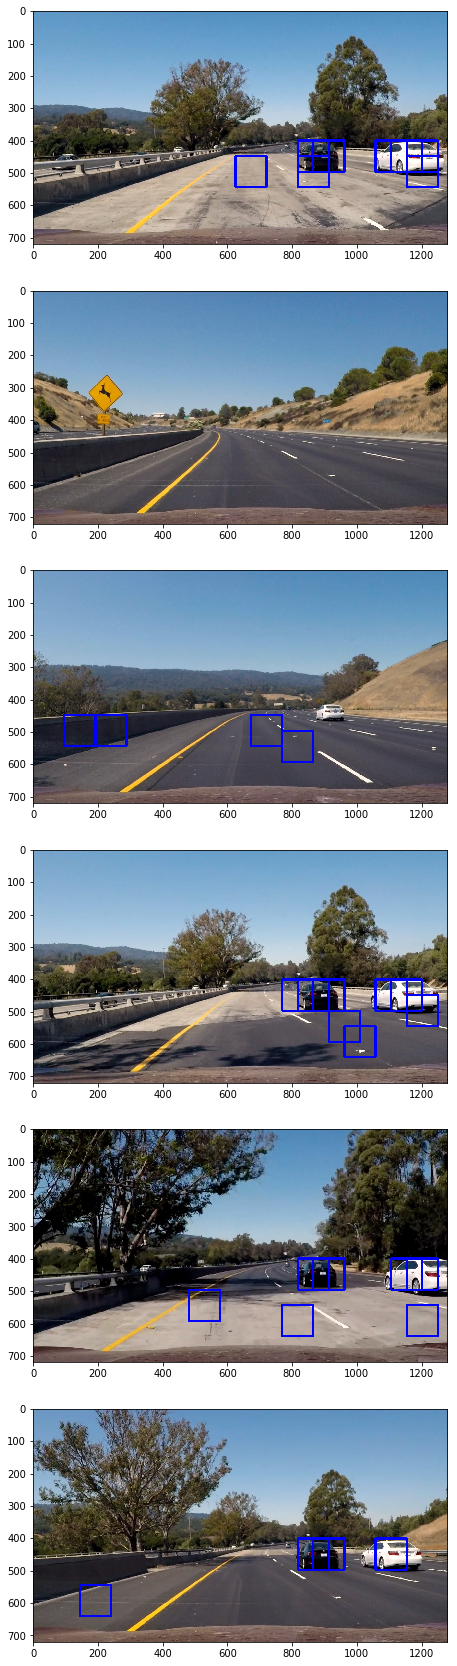

In [109]:

## Quickly check how well the model works on the test images
## using a basic way of doing the windowing.
## A different windowing method is used in the pipeline.


img_fnames_wild = "./test_images/*.jpg"
example_img_fnames = glob.glob(img_fnames_wild)

images = []
titles = []
y_start_stop = [400, 656]
xy_window = (96,96)
overlap = 0.5

for img_fname in example_img_fnames:

    image = mpimg.imread(img_fname)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    # Check that the values within image are reasonable (abs(val) < 1)
    print('min:',np.min(image),'max:',np.max(image))

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(overlap, overlap))

    hot_windows = search_windows(image, windows, svc, X_train_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    images.append(window_img)
          
plot_images(images,6,1,figsize=(10,30),titles=titles,fontsize=36,
            saveas="./output_images/simple_windowing.jpg")



py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



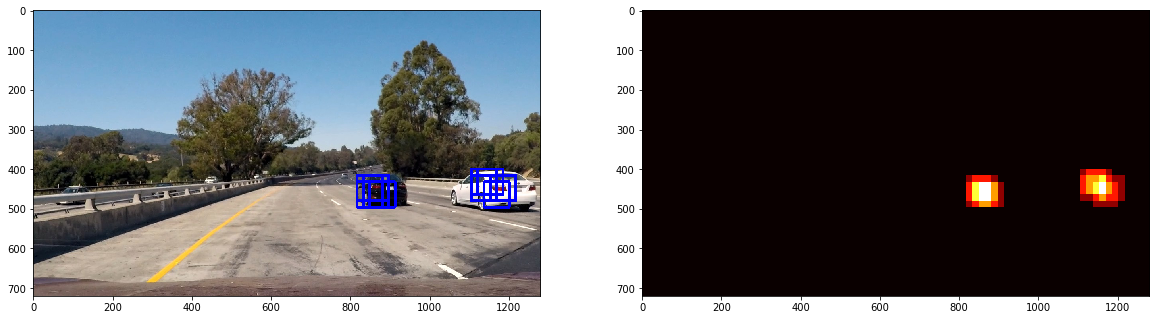

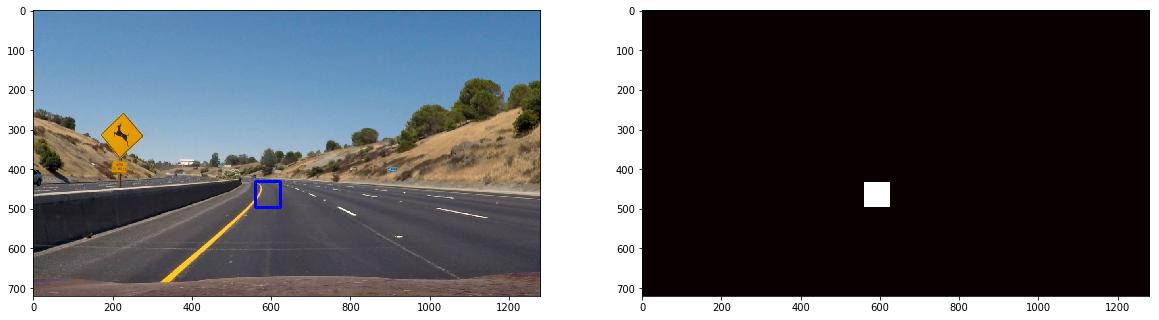

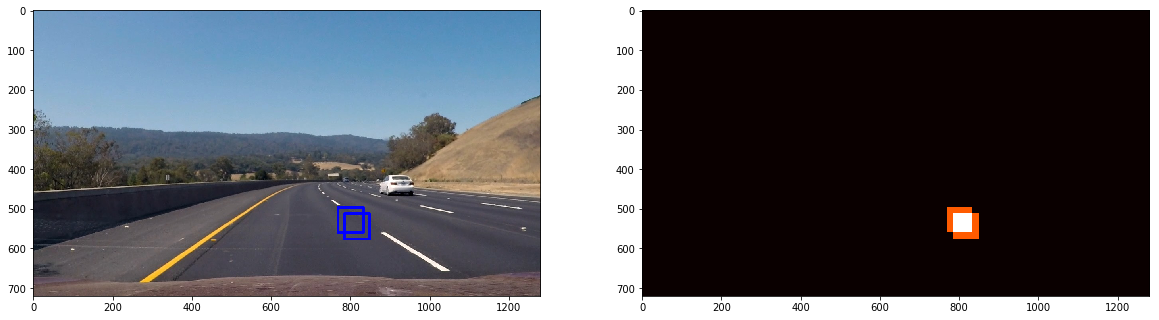

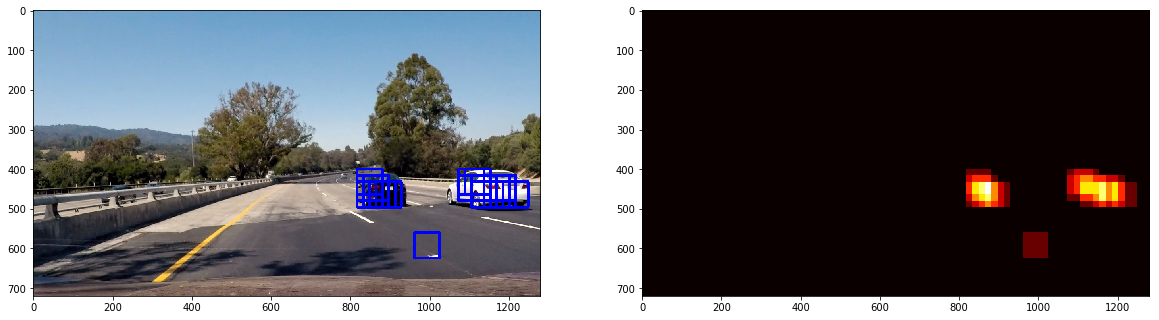

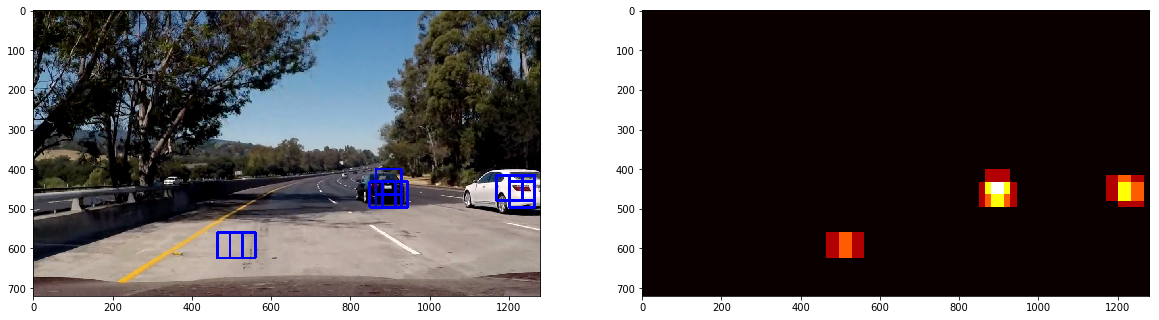

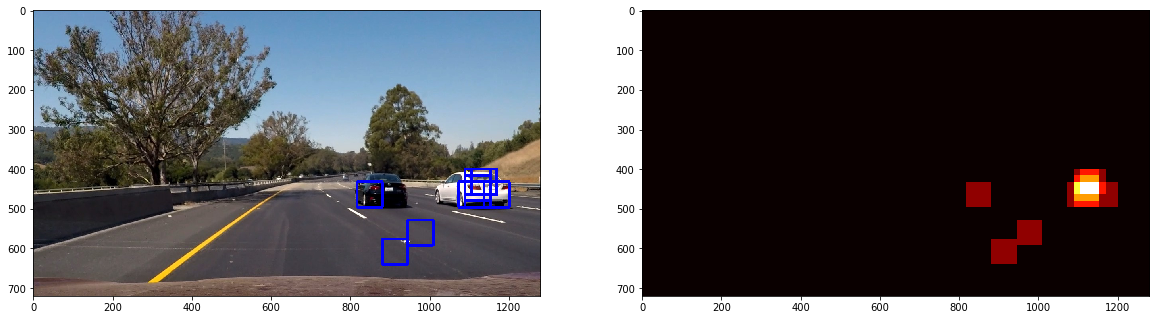

In [110]:
## Test the model on the test images again.
## Use the find_cars method for with windowing, which is faster
## because it computes the HOG features just once for the full image
## instead of for every window.


img_fnames_wild = "./test_images/*.jpg"
example_img_fnames = glob.glob(img_fnames_wild)

y_start_stop = [400, 656]
#xy_window = (96,96) # Set scale instead of xy_window
#overlap = 0.5 # Overlap is hardcoded as 75% in find_cars
scale = 1


ystart = y_start_stop[0]
ystop = y_start_stop[1]
out_images = []
titles = []
heatmaps = []
box_lists = []

for img_fname in example_img_fnames:

    image = mpimg.imread(img_fname)
    #draw_image = np.copy(image)

    out_image, heatmap, box_list = find_cars(image, ystart, ystop, scale, 
                                             svc, X_train_scaler, orient, 
                                             pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins)
    
    out_images.append(out_image)
    heatmaps.append(heatmap)
    box_lists.append(box_list)
    
for idx in range(len(out_images)):
    
    plot_images([out_images[idx],heatmaps[idx]],1,2,figsize=(20,10),cmap='hot',titles=titles,fontsize=36,
                saveas="./output_images/find_cars.jpg")


py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



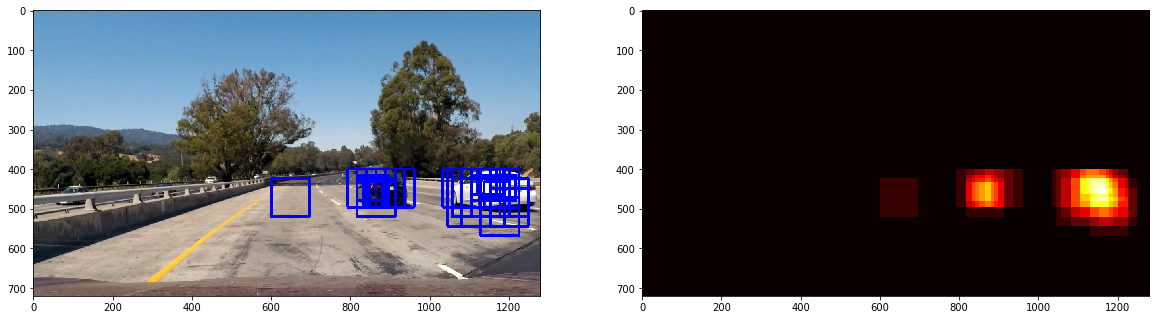

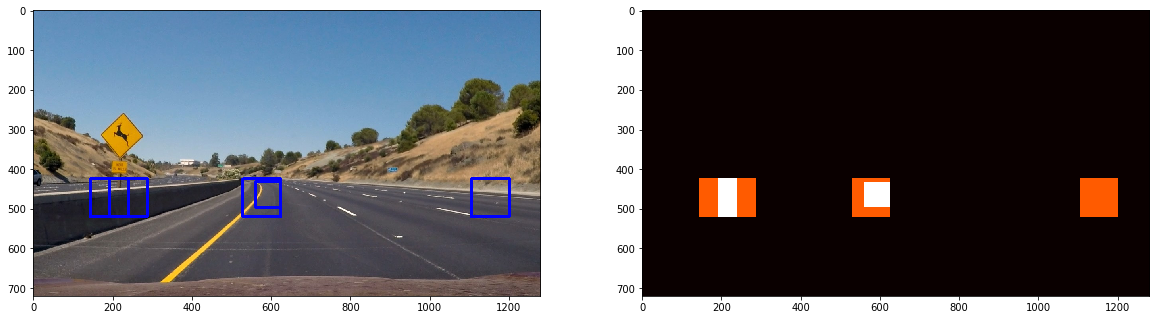

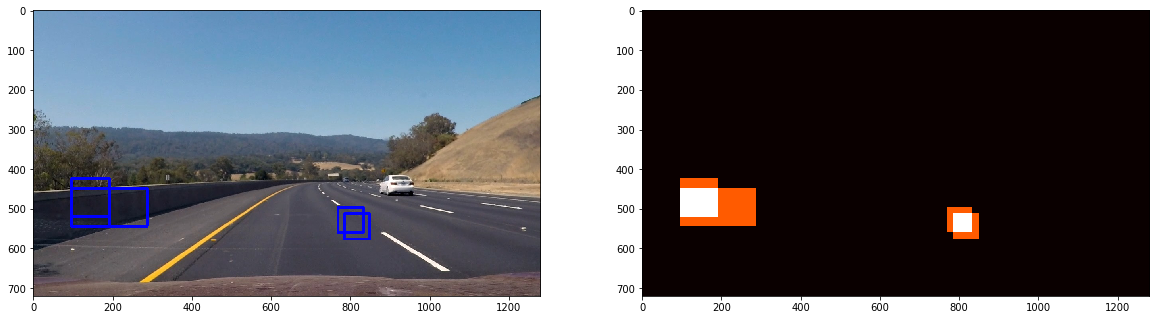

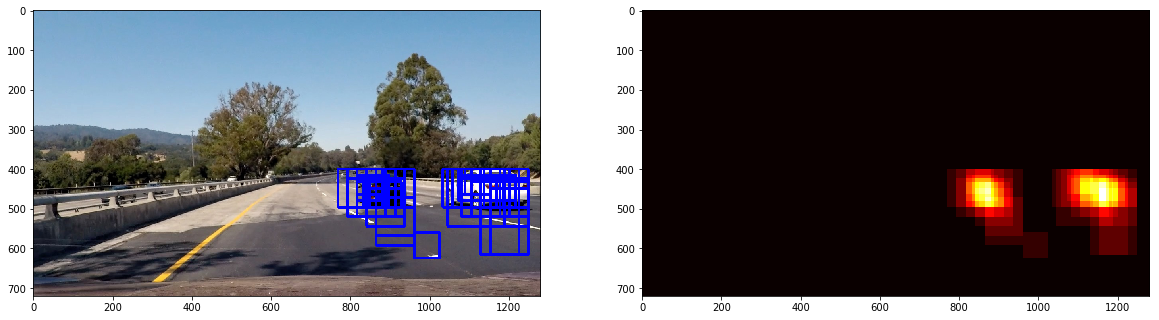

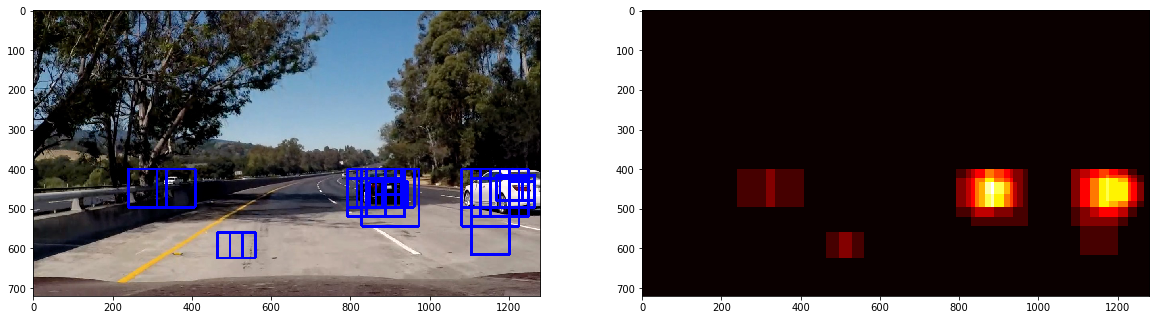

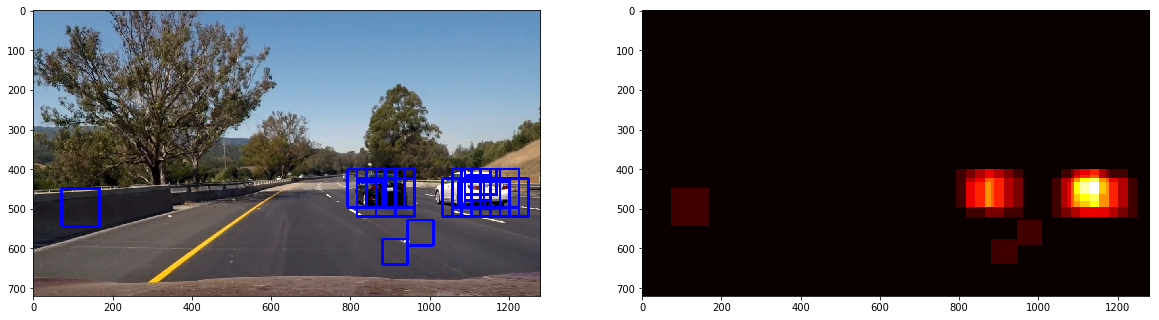

In [111]:
## Test the model on the test images again.
## Instead of using find_cars() like the previous cell,
## use find_cars_many_scales() to allow for multiple window sizes.


img_fnames_wild = "./test_images/*.jpg"
example_img_fnames = glob.glob(img_fnames_wild)

y_start_stop = [400, 656]
#xy_window = (96,96) # Set scale instead of xy_window
#overlap = 0.5 # Overlap is hardcoded as 75% in find_cars
#scales = [0.8,1.3,2]
scales = [1,1.5,2.25]


ystart = y_start_stop[0]
ystop = y_start_stop[1]
out_images = []
titles = []
heatmaps = []
box_lists = []

for img_fname in example_img_fnames:

    image = mpimg.imread(img_fname)
    #draw_image = np.copy(image)

    out_image, heatmap, box_list = find_cars_many_scales(image, 
                                             ystart, ystop, scales, 
                                             svc, X_train_scaler, orient, 
                                             pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins)
    
    out_images.append(out_image)
    heatmaps.append(heatmap)
    box_lists.append(box_list)
    
for idx in range(len(out_images)):
    
    plot_images([out_images[idx],heatmaps[idx]],1,2,figsize=(20,10),cmap='hot',titles=titles,fontsize=36,
                saveas="./output_images/find_cars_many_scales.jpg")


py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



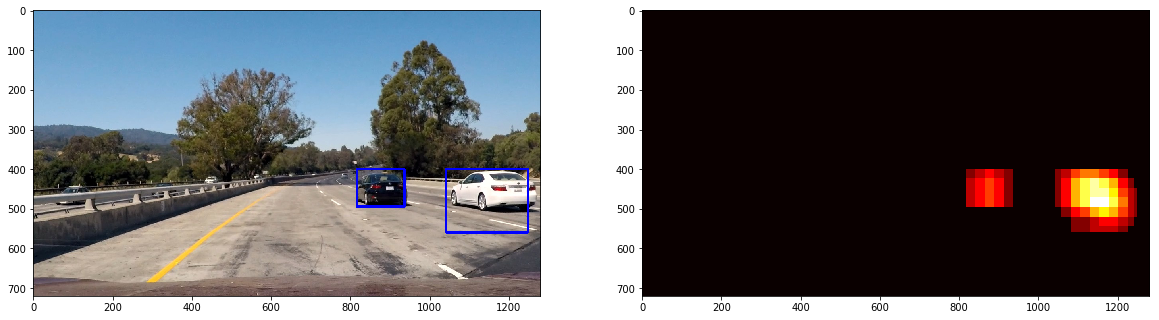

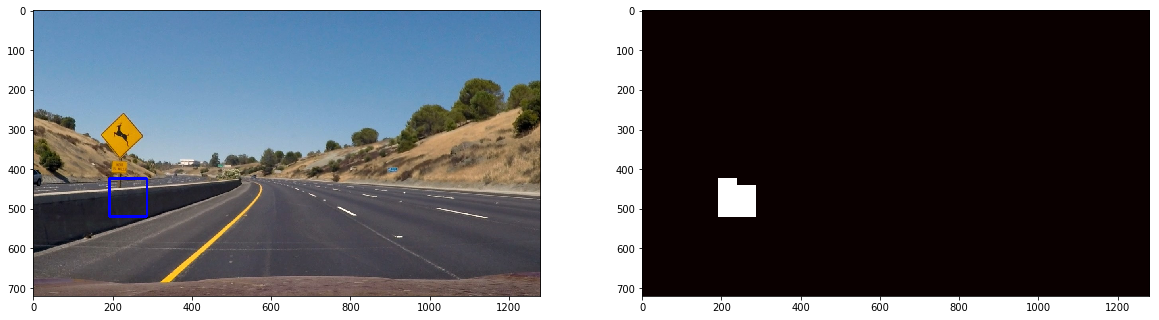

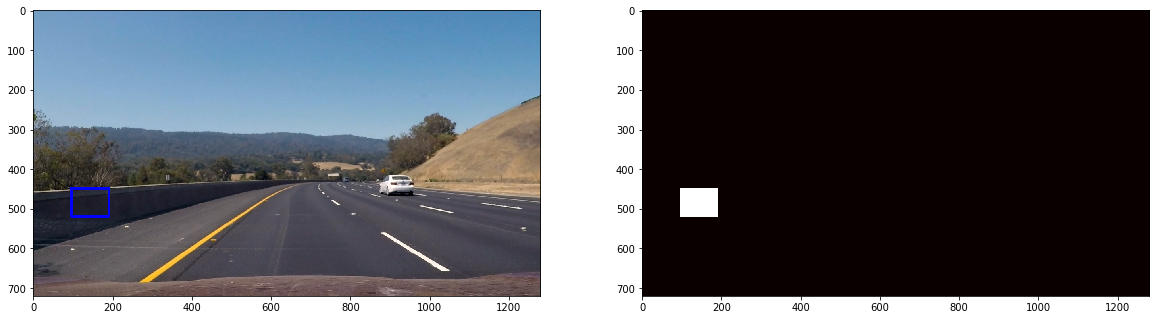

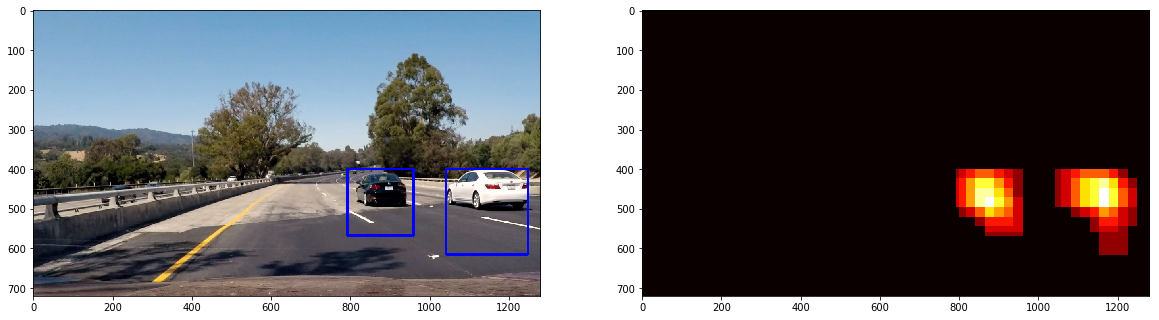

In [112]:
## This time, use the heatmap output from find_cars_many_scales combined 
## with a heatmap threshold to remove many of the false positives.

y_start_stop = [400, 656]
#scales = [0.8,1.3,2]
scales = [1.5,2.5]

heat_thresh = 1


ystart = y_start_stop[0]
ystop = y_start_stop[1]

titles = []
heatmaps = []
box_lists = []
out_images = []

label_images = []
thresh_heatmaps = []

for img_fname in example_img_fnames:

    image = mpimg.imread(img_fname)
    #draw_image = np.copy(image)
    
    out_image, heatmap, box_list = find_cars_many_scales(image, 
                                             ystart, ystop, scales, 
                                             svc, X_train_scaler, orient, 
                                             pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins)
    
    out_images.append(out_image)
    heatmaps.append(heatmap)
    box_lists.append(box_list)
    
    thresh_heatmap = apply_threshold(heatmap,heat_thresh)

    # Visualize the heatmap when displaying    
    thresh_heatmap = np.clip(thresh_heatmap, 0, 255)
    thresh_heatmaps.append(thresh_heatmap)

    # Find final boxes from heatmap using label function
    labels = label(thresh_heatmap)
    label_image = draw_labeled_bboxes(np.copy(image), labels)
    label_images.append(label_image)
    
    
for idx in range(len(label_images)):
    
    plot_images([label_images[idx],thresh_heatmaps[idx]],1,2,figsize=(20,10),cmap='hot',titles=titles,fontsize=36,
                saveas="./output_images/thresholded.jpg")    

In [113]:
output_heatmap = False
# Need to set heatmap_deque to be an empty deque
def process_image(image):
    
    global recent_heatmaps

    # If heatmap_deque hasn't been declared to be a deque
    # then create it. This should only occur fo the first
    # video frame.
    if 'recent_heatmaps' not in globals():
        
        recent_heatmaps = []
            
    
    
    out_image, heatmap, box_list = find_cars_many_scales(image, 
                                             ystart, ystop, scales, 
                                             svc, X_train_scaler, orient, 
                                             pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins)
    # If heatmap history gets too large, remove the oldest element
    recent_heatmaps.insert(0,heatmap)
    if (len(recent_heatmaps) > n_history):
        recent_heatmaps.pop()
        
    heatmap_sum = np.sum(recent_heatmaps,axis=0)
    
        
    thresh_heatmap = apply_threshold(heatmap_sum,
                                     heat_thresh_ave*n_history)  
    thresh_heatmap = np.clip(thresh_heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(thresh_heatmap)
    label_image = draw_labeled_bboxes(np.copy(image), labels)
    
    if output_heatmap == True:
        return thresh_heatmap
    else:
        return label_image
    

py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



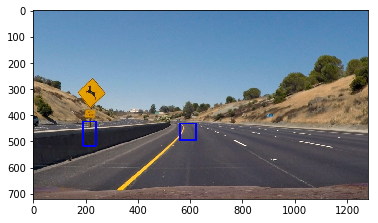

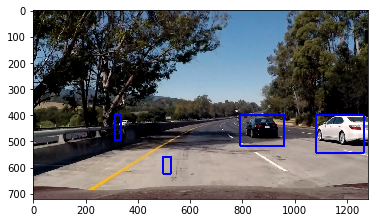

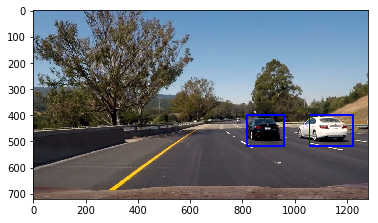

In [114]:
### Test the pipeline on the test images

images = []
for img_fname in example_img_fnames:

    image = mpimg.imread(img_fname)
    
    scales = [1.0,1.5,2.25]
    heat_thresh_ave = 1
    recent_heatmaps = []
    n_history = 1
    
    out_image = process_image(image)
    #fig = plt.figure()
    #plt.imshow(out_image)
    #display(fig)
    #plt.close()
    
    images.append(out_image)
    
plot_images(images,6,1,figsize=(10,30),titles=titles,fontsize=36,
            saveas="./output_images/test_pipeline.jpg")
    

In [ ]:
# Plot six consecutive images that demonstrate the pipeline
# Set n_history = 1, so heatmaps are not cumulative

image_fnames = blob.blob("consecutive_images/*.png")

scales = [1.0,1.5,2.25]
    heat_thresh_ave = 1
    recent_heatmaps = []
    n_history = 1

images = []
for img_fname in image_fnames:

    image = mpimg.imread(img_fname)
    
    output_heatmap = False
    out_image = process_image(image)
    
    output_heatmap = True
    thresh_heatmap = process_image(image)
        
    images.append(out_image)
    images.append(thresh_heatmap)
    
plot_images(images,6,2,figsize=(10,30),titles=titles,fontsize=36,
            saveas="./output_images/pipeline_no_history.jpg")
    
    

In [ ]:
# Plot six consecutive images that demonstrate the pipeline
# Set n_history = 6, so heatmaps are not cumulative

image_fnames = blob.blob("consecutive_images/*.png")

scales = [1.0,1.5,2.25]
    heat_thresh_ave = 1
    recent_heatmaps = []
    n_history = 1

images = []
for img_fname in image_fnames:

    image = mpimg.imread(img_fname)
    
    output_heatmap = False
    out_image = process_image(image)
    
    output_heatmap = True
    thresh_heatmap = process_image(image)
        
    images.append(out_image)
    images.append(thresh_heatmap)
    
plot_images(images,6,2,figsize=(10,30),titles=titles,fontsize=36,
            saveas="./output_images/pipeline_history.jpg")
    
    

In [ ]:
video_name = 'project_video.mp4'
#video_name = 'test_video.mp4'
video_output_name = 'test_output.mp4'

heat_thresh_ave = 7
n_history=20
recent_heatmaps = [] # Very important to delete history before starting
# Define clip1 once by uncommenting one the following lines for 
# various subclips of interst.
#clip1 = VideoFileClip(video_name).subclip(38,43) #Shady area
#clip1 = VideoFileClip(video_name).subclip(9,13) # switch from curve to straight
clip1 = VideoFileClip(video_name) # The full video
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output_name, audio=False)

py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]py.warnings : WARNING  /Users/amorten/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

 78%|███████▊  | 989/1261 [31:16<08:42,  1.92s/it]